# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [ ]:
!pip install .

In [ ]:
!pip install protobuf==3.20.3

## Restart the Kernel
Restart the Kernel, and verify the protobuf version. 

In [ ]:
import google.protobuf
print(google.protobuf.__version__)


## Instructions
The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [ ]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [ ]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [ ]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [ ]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

# My Implementation

In [ ]:
!pip install torch

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque, namedtuple
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from unityagents import UnityEnvironment
from tqdm import tqdm
import os
import json
from datetime import datetime
import copy

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [2]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""
    
    def __init__(self, state_size, action_size, seed, fc1_units=256, fc2_units=128):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        if state.dim() == 1:
            state = state.unsqueeze(0)
        x = F.relu(self.bn1(self.fc1(state)))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""
    
    def __init__(self, full_state_size, full_action_size, seed, fcs1_units=256, fc2_units=128):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(full_state_size, fcs1_units)
        self.bn1 = nn.BatchNorm1d(fcs1_units)
        self.fc2 = nn.Linear(fcs1_units + full_action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        if state.dim() == 1:
            state = state.unsqueeze(0)
        xs = F.relu(self.bn1(self.fcs1(state)))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [3]:
class ReplayBuffer:
    """Fixed replay buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size, seed):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", 
                                    field_names=["states", "actions", "rewards", "next_states", "dones"])
        random.seed(seed)
        np.random.seed(seed)
    
    def add(self, states, actions, rewards, next_states, dones):
        """Add a new experience to memory."""
        e = self.experience(states, actions, rewards, next_states, dones)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.FloatTensor(np.array([e.states for e in experiences])).to(device)
        actions = torch.FloatTensor(np.array([e.actions for e in experiences])).to(device)
        rewards = torch.FloatTensor(np.array([e.rewards for e in experiences])).to(device)
        next_states = torch.FloatTensor(np.array([e.next_states for e in experiences])).to(device)
        dones = torch.FloatTensor(np.array([e.dones for e in experiences])).to(device)
        
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        return len(self.memory)

In [4]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.01):
        """Initialize parameters and noise process.
        Note: Using lower sigma (0.05) for more stable learning."""
        self.size = size
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

In [5]:
class DDPGAgent:
    """Single DDPG Agent."""
    
    def __init__(self, state_size, action_size, agent_id, num_agents, random_seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        self.agent_id = agent_id
        self.num_agents = num_agents
        
        # Hyperparameters
        self.lr_actor = 5e-4  
        self.lr_critic = 1e-3
        self.weight_decay = 0
        self.tau = 5e-3
        self.gamma = 0.99
        
        # Actor Network
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=self.lr_actor)
        
        # Critic Network
        self.critic_local = Critic(state_size * num_agents, 
                                  action_size * num_agents, 
                                  random_seed).to(device)
        self.critic_target = Critic(state_size * num_agents, 
                                   action_size * num_agents, 
                                   random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), 
                                          lr=self.lr_critic, 
                                          weight_decay=self.weight_decay)
        
        # Initialize target networks
        self.hard_update()
    
    def hard_update(self):
        """Hard update model parameters."""
        for target_param, local_param in zip(self.actor_target.parameters(), 
                                            self.actor_local.parameters()):
            target_param.data.copy_(local_param.data)
            
        for target_param, local_param in zip(self.critic_target.parameters(), 
                                            self.critic_local.parameters()):
            target_param.data.copy_(local_param.data)
    
    def act(self, state):
        """Returns actions for given state."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        return action.flatten()
    
    def learn_critic(self, states, actions, rewards, next_states, next_actions, dones):
        """Update critic network."""
        Q_targets_next = self.critic_target(next_states, next_actions)
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()
    
    def learn_actor(self, states, predicted_actions):
        """Update actor network."""
        actor_loss = -self.critic_local(states, predicted_actions).mean()
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor_local.parameters(), 1)
        self.actor_optimizer.step()
    
    def soft_update(self):
        """Soft update model parameters."""
        for target_param, local_param in zip(self.actor_target.parameters(), 
                                            self.actor_local.parameters()):
            target_param.data.copy_(self.tau * local_param.data + 
                                   (1.0 - self.tau) * target_param.data)
            
        for target_param, local_param in zip(self.critic_target.parameters(), 
                                            self.critic_local.parameters()):
            target_param.data.copy_(self.tau * local_param.data + 
                                   (1.0 - self.tau) * target_param.data)


In [6]:
class MADDPGAgent:
    """Multi-Agent DDPG."""
    
    def __init__(self, state_size, action_size, num_agents, random_seed):
        self.state_size = state_size
        self.action_size = action_size
        self.num_agents = num_agents
        self.seed = random.seed(random_seed)
        
        # Hyperparameters
        self.buffer_size = int(1e6)
        self.batch_size = 64
        self.update_every = 1
        self.num_updates = 5  
        
        # Create agents
        self.agents = []
        for i in range(num_agents):
            agent = DDPGAgent(state_size, action_size, i, num_agents, random_seed)
            self.agents.append(agent)
        
        # Shared replay buffer
        self.memory = ReplayBuffer(self.buffer_size, self.batch_size, random_seed)
        
        # Noise process
        self.noise = OUNoise((num_agents, action_size), random_seed, sigma=0.05)
        self.t_step = 0
    
    def reset(self):
        """Reset noise."""
        self.noise.reset()
    
    def act(self, states, add_noise=True):
        """Get actions from all agents."""
        actions = np.zeros((self.num_agents, self.action_size))
        
        for i, agent in enumerate(self.agents):
            action = agent.act(states[i])
            actions[i] = action
        
        if add_noise:
            actions += self.noise.sample()
        
        return np.clip(actions, -1, 1)
    
    def step(self, states, actions, rewards, next_states, dones):
        """Save experience and learn."""
        self.memory.add(states, actions, rewards, next_states, dones)
        
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            if len(self.memory) > self.batch_size:
                for _ in range(self.num_updates):
                    experiences = self.memory.sample()
                    self.learn(experiences)
    
    def learn(self, experiences):
        """Update all agents."""
        states, actions, rewards, next_states, dones = experiences
        
        # Reshape for proper dimensions
        batch_size = states.shape[0]
        states_full = states.view(batch_size, -1)
        next_states_full = next_states.view(batch_size, -1)
        actions_full = actions.view(batch_size, -1)
        
        # Update each agent
        for agent_idx, agent in enumerate(self.agents):
            # Agent-specific rewards and dones
            agent_rewards = rewards[:, agent_idx].unsqueeze(-1)
            agent_dones = dones[:, agent_idx].unsqueeze(-1)
            
            # Get next actions from all agents
            next_actions = []
            for i, other_agent in enumerate(self.agents):
                next_action = other_agent.actor_target(next_states[:, i, :])
                next_actions.append(next_action)
            next_actions_full = torch.cat(next_actions, dim=1)
            
            # Update critic
            agent.learn_critic(states_full, actions_full, agent_rewards, 
                              next_states_full, next_actions_full, agent_dones)
            
            # Get current actions for actor update
            predicted_actions = []
            for i, other_agent in enumerate(self.agents):
                if i == agent_idx:
                    predicted_action = agent.actor_local(states[:, i, :])
                else:
                    predicted_action = other_agent.actor_local(states[:, i, :]).detach()
                predicted_actions.append(predicted_action)
            predicted_actions_full = torch.cat(predicted_actions, dim=1)
            
            # Update actor
            agent.learn_actor(states_full, predicted_actions_full)
            
            # Soft update target networks
            agent.soft_update()

In [7]:
class Config:
    def __init__(self):
        self.env_path = "/data/Tennis_Linux_NoVis/Tennis"
        self.episodes = 2000
        self.max_t = 1000
        self.save_every = 100
        self.print_every = 100
        self.save_threshold = 0.5
        self.seed = 42
        self.warmup_episodes = 300

def set_seeds(seed):
    """Set all random seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

In [8]:
def train_maddpg(env, agent, config):
    """Train the MADDPG agent."""
    brain_name = env.brain_names[0]
    
    scores_deque = deque(maxlen=100)
    scores_list = []
    avg_scores_list = []
    max_avg_score = -np.inf
    
    # Warm-up phase with random actions
    print(f"🔥 Warm-up phase: {config.warmup_episodes} episodes with random actions")
    for i in tqdm(range(config.warmup_episodes), desc="Warm-up"):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        
        for t in range(config.max_t):
            actions = np.random.randn(agent.num_agents, agent.action_size)
            actions = np.clip(actions, -1, 1)
            
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            
            # No need to amplify during warm-up - just store raw experiences
            agent.memory.add(states, actions, rewards, next_states, dones)
            states = next_states
            
            if np.any(dones):
                break
    
    print(f"✓ Warm-up complete. Buffer size: {len(agent.memory)}")
    
    # Training loop
    print("\n🚀 Starting training...")
    with tqdm(range(1, config.episodes + 1), desc="Training") as pbar:
        for i_episode in pbar:
            env_info = env.reset(train_mode=True)[brain_name]
            states = env_info.vector_observations
            agent.reset()
            scores = np.zeros(agent.num_agents)  # Initialize scores for this episode
            
            for t in range(config.max_t):
                # Get actions
                actions = agent.act(states, add_noise=True)
                
                # Step environment
                env_info = env.step(actions)[brain_name]
                next_states = env_info.vector_observations
                rewards = env_info.rewards
                dones = env_info.local_done
                
                # Amplify rewards for learning (helps with sparse rewards)
                amplified_rewards = np.array(rewards) * 5.0
                
                # Store experience with amplified rewards for better learning
                agent.step(states, actions, amplified_rewards, next_states, dones)
                
                states = next_states
                scores += rewards  # Use original rewards for accurate scoring
                
                if np.any(dones):
                    break
            
            # Track scores
            max_score = np.max(scores)
            scores_deque.append(max_score)
            scores_list.append(max_score)
            avg_score = np.mean(scores_deque)
            avg_scores_list.append(avg_score)
            
            # Update progress bar
            pbar.set_postfix({'Avg': f'{avg_score:.3f}', 'Max': f'{max_score:.3f}'})
            
            # Print progress
            if i_episode % config.print_every == 0:
                tqdm.write(f'Episode {i_episode}\tAverage Score: {avg_score:.3f}')
            
            # Save best model
            if avg_score > max_avg_score:
                max_avg_score = avg_score
                if avg_score > 0.01:  # Only save meaningful improvements
                    for idx, ddpg_agent in enumerate(agent.agents):
                        torch.save(ddpg_agent.actor_local.state_dict(), 
                                 f'best_actor_{idx}.pth')
                        torch.save(ddpg_agent.critic_local.state_dict(), 
                                 f'best_critic_{idx}.pth')
                    if avg_score > 0.1:  # Announce milestones
                        tqdm.write(f'★ New best: {avg_score:.3f}')
            
            # Check if solved
            if avg_score >= config.save_threshold:
                tqdm.write(f'\n🎉 Environment solved in {i_episode} episodes!')
                tqdm.write(f'Average Score: {avg_score:.3f}')
                
                # Save final model
                for idx, ddpg_agent in enumerate(agent.agents):
                    torch.save(ddpg_agent.actor_local.state_dict(), 
                             f'solved_actor_{idx}.pth')
                    torch.save(ddpg_agent.critic_local.state_dict(), 
                             f'solved_critic_{idx}.pth')
                break
    
    return scores_list, avg_scores_list

In [9]:
def plot_scores(scores, avg_scores):
    """Plot training progress."""
    fig = plt.figure(figsize=(12, 5))
    
    # Episode scores
    ax1 = fig.add_subplot(121)
    ax1.plot(scores, alpha=0.5, color='blue', label='Episode Score')
    ax1.plot(avg_scores, color='red', linewidth=2, label='Average (100 eps)')
    ax1.axhline(y=0.5, color='green', linestyle='--', label='Target')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Score')
    ax1.set_title('Training Progress')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Moving average
    ax2 = fig.add_subplot(122)
    ax2.plot(avg_scores, color='red', linewidth=2)
    ax2.fill_between(range(len(avg_scores)), avg_scores, alpha=0.3, color='red')
    ax2.axhline(y=0.5, color='green', linestyle='--', label='Target')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Average Score')
    ax2.set_title('100-Episode Moving Average')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_progress.png')
    plt.show()
    
    return fig


In [10]:
def test_agent(env, agent, n_episodes=10):
    """Test the trained agent."""
    brain_name = env.brain_names[0]
    scores = []
    
    for i_episode in range(1, n_episodes + 1):
        env_info = env.reset(train_mode=False)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        episode_scores = np.zeros(agent.num_agents)
        
        while True:
            actions = agent.act(states, add_noise=False)
            env_info = env.step(actions)[brain_name]
            states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            episode_scores += rewards
            
            if np.any(dones):
                break
        
        score = np.max(episode_scores)
        scores.append(score)
        print(f'Episode {i_episode}: {score:.3f}')
    
    print(f'\nAverage Score: {np.mean(scores):.3f}')
    return scores

In [11]:
def main():
    # Configuration
    config = Config()
    set_seeds(config.seed)
    
    print("🎮 Tennis Environment MADDPG Training")
    print(f"📍 Device: {device}")
    print("=" * 50)
    
    # Initialize environment
    env = UnityEnvironment(file_name=config.env_path)
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    env_info = env.reset(train_mode=True)[brain_name]
    
    # Environment info
    num_agents = len(env_info.agents)
    state_size = env_info.vector_observations.shape[1]
    action_size = brain.vector_action_space_size
    
    print(f"Agents: {num_agents}")
    print(f"State size: {state_size}")
    print(f"Action size: {action_size}")
    print("=" * 50)
    
    # Create agent
    agent = MADDPGAgent(state_size, action_size, num_agents, config.seed)
    
    # Train
    scores, avg_scores = train_maddpg(env, agent, config)
    
    # Plot results
    if scores:
        plot_scores(scores, avg_scores)
        print(f"\n📊 Best average score: {max(avg_scores):.3f}")
        
        # Test the trained agent
        print("\n🎮 Testing trained agent...")
        test_scores = test_agent(env, agent, n_episodes=10)
    
    # Close environment
    env.close()
    print("\n✅ Complete!")
    
    return agent, scores

🎮 Tennis Environment MADDPG Training
📍 Device: cuda:0
Found path: /data/Tennis_Linux_NoVis/Tennis.x86_64
Mono path[0] = '/data/Tennis_Linux_NoVis/Tennis_Data/Managed'
Mono config path = '/data/Tennis_Linux_NoVis/Tennis_Data/MonoBleedingEdge/etc'
Preloaded 'libgrpc_csharp_ext.x64.so'
Unable to preload the following plugins:
	libgrpc_csharp_ext.x86.so
Logging to /home/student/.config/unity3d/Unity Technologies/Unity Environment/Player.log


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Agents: 2
State size: 24
Action size: 2
🔥 Warm-up phase: 300 episodes with random actions


Warm-up: 100%|██████████| 300/300 [00:57<00:00,  5.23it/s]


✓ Warm-up complete. Buffer size: 5557

🚀 Starting training...


Training:   5%|▌         | 100/2000 [02:47<1:18:30,  2.48s/it, Avg=0.005, Max=0.090]

Episode 100	Average Score: 0.005


Training:  10%|█         | 200/2000 [07:32<3:39:00,  7.30s/it, Avg=0.058, Max=0.100]

Episode 200	Average Score: 0.058


Training:  14%|█▎        | 273/2000 [13:03<8:52:16, 18.49s/it, Avg=0.103, Max=1.200]

★ New best: 0.103


Training:  14%|█▍        | 275/2000 [13:18<6:29:13, 13.54s/it, Avg=0.105, Max=0.300]

★ New best: 0.105


Training:  14%|█▍        | 276/2000 [13:30<6:12:10, 12.95s/it, Avg=0.107, Max=0.300]

★ New best: 0.107


Training:  14%|█▍        | 277/2000 [13:33<4:48:16, 10.04s/it, Avg=0.108, Max=0.100]

★ New best: 0.108


Training:  14%|█▍        | 278/2000 [14:09<8:36:15, 17.99s/it, Avg=0.117, Max=0.900]

★ New best: 0.117


Training:  14%|█▍        | 281/2000 [14:17<3:50:10,  8.03s/it, Avg=0.117, Max=0.100]

★ New best: 0.117


Training:  14%|█▍        | 282/2000 [14:21<3:09:35,  6.62s/it, Avg=0.117, Max=0.100]

★ New best: 0.117


Training:  14%|█▍        | 283/2000 [14:37<4:29:08,  9.41s/it, Avg=0.120, Max=0.400]

★ New best: 0.120


Training:  14%|█▍        | 285/2000 [14:52<4:18:28,  9.04s/it, Avg=0.123, Max=0.300]

★ New best: 0.123


Training:  14%|█▍        | 286/2000 [15:20<7:03:11, 14.81s/it, Avg=0.128, Max=0.690]

★ New best: 0.128


Training:  14%|█▍        | 287/2000 [15:30<6:18:17, 13.25s/it, Avg=0.129, Max=0.200]

★ New best: 0.129


Training:  15%|█▍        | 292/2000 [15:43<2:12:19,  4.65s/it, Avg=0.130, Max=0.100]

★ New best: 0.130


Training:  15%|█▍        | 293/2000 [15:46<1:59:55,  4.22s/it, Avg=0.130, Max=0.090]

★ New best: 0.130


Training:  15%|█▍        | 296/2000 [15:55<1:41:36,  3.58s/it, Avg=0.131, Max=0.090]

★ New best: 0.131


Training:  15%|█▍        | 297/2000 [15:59<1:41:37,  3.58s/it, Avg=0.132, Max=0.100]

★ New best: 0.132


Training:  15%|█▌        | 300/2000 [16:07<1:28:53,  3.14s/it, Avg=0.126, Max=0.090]

Episode 300	Average Score: 0.126


Training:  15%|█▌        | 309/2000 [17:09<4:52:34, 10.38s/it, Avg=0.134, Max=0.500]

★ New best: 0.134


Training:  16%|█▌        | 311/2000 [17:24<4:20:47,  9.26s/it, Avg=0.136, Max=0.300]

★ New best: 0.136


Training:  16%|█▌        | 312/2000 [17:27<3:31:04,  7.50s/it, Avg=0.136, Max=0.100]

★ New best: 0.136


Training:  16%|█▌        | 313/2000 [17:31<2:56:03,  6.26s/it, Avg=0.137, Max=0.090]

★ New best: 0.137


Training:  16%|█▌        | 315/2000 [17:37<2:14:04,  4.77s/it, Avg=0.138, Max=0.090]

★ New best: 0.138


Training:  16%|█▌        | 317/2000 [17:53<3:04:51,  6.59s/it, Avg=0.140, Max=0.300]

★ New best: 0.140


Training:  16%|█▌        | 322/2000 [18:22<3:32:13,  7.59s/it, Avg=0.143, Max=0.400]

★ New best: 0.143


Training:  16%|█▋        | 328/2000 [18:52<3:14:02,  6.96s/it, Avg=0.144, Max=0.300]

★ New best: 0.144


Training:  16%|█▋        | 329/2000 [18:55<2:42:03,  5.82s/it, Avg=0.144, Max=0.100]

★ New best: 0.144


Training:  17%|█▋        | 331/2000 [20:47<16:40:16, 35.96s/it, Avg=0.169, Max=2.600]

★ New best: 0.169


Training:  17%|█▋        | 333/2000 [21:38<15:14:37, 32.92s/it, Avg=0.180, Max=1.200]

★ New best: 0.180


Training:  17%|█▋        | 334/2000 [21:52<12:36:02, 27.23s/it, Avg=0.182, Max=0.300]

★ New best: 0.182


Training:  17%|█▋        | 338/2000 [22:12<5:17:42, 11.47s/it, Avg=0.184, Max=0.300] 

★ New best: 0.184


Training:  17%|█▋        | 339/2000 [22:21<5:01:20, 10.89s/it, Avg=0.185, Max=0.190]

★ New best: 0.185


Training:  17%|█▋        | 340/2000 [22:29<4:33:15,  9.88s/it, Avg=0.186, Max=0.200]

★ New best: 0.186


Training:  17%|█▋        | 342/2000 [23:54<13:48:08, 29.97s/it, Avg=0.205, Max=1.900]

★ New best: 0.205


Training:  17%|█▋        | 344/2000 [24:18<9:43:34, 21.14s/it, Avg=0.206, Max=0.300] 

★ New best: 0.206


Training:  17%|█▋        | 347/2000 [25:08<9:51:47, 21.48s/it, Avg=0.213, Max=1.000]

★ New best: 0.213


Training:  17%|█▋        | 348/2000 [25:16<7:56:11, 17.30s/it, Avg=0.214, Max=0.200]

★ New best: 0.214


Training:  18%|█▊        | 350/2000 [25:25<5:03:42, 11.04s/it, Avg=0.215, Max=0.200]

★ New best: 0.215


Training:  18%|█▊        | 351/2000 [26:24<11:42:04, 25.55s/it, Avg=0.228, Max=1.400]

★ New best: 0.228


Training:  18%|█▊        | 352/2000 [27:16<15:20:55, 33.53s/it, Avg=0.239, Max=1.200]

★ New best: 0.239


Training:  18%|█▊        | 355/2000 [27:47<8:49:26, 19.31s/it, Avg=0.242, Max=0.400] 

★ New best: 0.242


Training:  18%|█▊        | 356/2000 [28:46<14:19:59, 31.39s/it, Avg=0.255, Max=1.400]

★ New best: 0.255


Training:  18%|█▊        | 362/2000 [29:47<8:23:28, 18.44s/it, Avg=0.262, Max=1.000] 

★ New best: 0.262


Training:  18%|█▊        | 364/2000 [31:38<19:08:23, 42.12s/it, Avg=0.288, Max=2.600]

★ New best: 0.288


Training:  18%|█▊        | 365/2000 [32:19<19:02:48, 41.94s/it, Avg=0.297, Max=1.000]

★ New best: 0.297


Training:  18%|█▊        | 366/2000 [32:37<15:43:39, 34.65s/it, Avg=0.300, Max=0.400]

★ New best: 0.300


Training:  18%|█▊        | 367/2000 [32:43<11:44:57, 25.90s/it, Avg=0.301, Max=0.100]

★ New best: 0.301


Training:  18%|█▊        | 368/2000 [33:02<10:50:21, 23.91s/it, Avg=0.305, Max=0.500]

★ New best: 0.305


Training:  18%|█▊        | 370/2000 [34:18<15:25:16, 34.06s/it, Avg=0.317, Max=1.700]

★ New best: 0.317


Training:  19%|█▊        | 372/2000 [36:06<22:05:18, 48.84s/it, Avg=0.341, Max=2.600]

★ New best: 0.341


Training:  19%|█▊        | 373/2000 [37:30<26:55:53, 59.59s/it, Avg=0.350, Max=2.100]

★ New best: 0.350


Training:  19%|█▊        | 374/2000 [37:37<19:47:36, 43.82s/it, Avg=0.351, Max=0.100]

★ New best: 0.351


Training:  19%|█▉        | 375/2000 [39:23<28:12:00, 62.47s/it, Avg=0.374, Max=2.600]

★ New best: 0.374


Training:  19%|█▉        | 377/2000 [39:50<17:02:59, 37.82s/it, Avg=0.376, Max=0.400]

★ New best: 0.376


Training:  19%|█▉        | 380/2000 [40:58<14:31:28, 32.28s/it, Avg=0.383, Max=1.500]

★ New best: 0.383


Training:  19%|█▉        | 381/2000 [41:40<15:47:12, 35.10s/it, Avg=0.392, Max=1.000]

★ New best: 0.392


Training:  19%|█▉        | 383/2000 [43:14<20:09:47, 44.89s/it, Avg=0.410, Max=2.200]

★ New best: 0.410


Training:  19%|█▉        | 384/2000 [43:23<15:24:00, 34.31s/it, Avg=0.412, Max=0.200]

★ New best: 0.412


Training:  19%|█▉        | 388/2000 [44:37<10:55:02, 24.38s/it, Avg=0.418, Max=0.800]

★ New best: 0.418


Training:  19%|█▉        | 389/2000 [45:41<16:07:31, 36.03s/it, Avg=0.433, Max=1.500]

★ New best: 0.433


Training:  20%|█▉        | 390/2000 [45:44<11:41:28, 26.14s/it, Avg=0.433, Max=0.100]

★ New best: 0.433


Training:  20%|█▉        | 391/2000 [47:08<19:32:10, 43.71s/it, Avg=0.453, Max=2.100]

★ New best: 0.453


Training:  20%|█▉        | 392/2000 [47:18<14:55:33, 33.42s/it, Avg=0.454, Max=0.200]

★ New best: 0.454


Training:  20%|█▉        | 393/2000 [47:50<14:43:27, 32.99s/it, Avg=0.461, Max=0.800]

★ New best: 0.461


Training:  20%|█▉        | 394/2000 [48:14<13:30:32, 30.28s/it, Avg=0.466, Max=0.600]

★ New best: 0.466


Training:  20%|█▉        | 395/2000 [48:23<10:44:28, 24.09s/it, Avg=0.467, Max=0.200]

★ New best: 0.467


Training:  20%|█▉        | 396/2000 [48:29<8:14:55, 18.51s/it, Avg=0.467, Max=0.100] 

★ New best: 0.467


Training:  20%|█▉        | 398/2000 [48:35<4:44:47, 10.67s/it, Avg=0.468, Max=0.100]

★ New best: 0.468


Training:  20%|██        | 400/2000 [48:42<3:13:16,  7.25s/it, Avg=0.467, Max=0.100]

Episode 400	Average Score: 0.467


Training:  20%|██        | 401/2000 [48:51<3:21:41,  7.57s/it, Avg=0.468, Max=0.200]

★ New best: 0.468


Training:  20%|██        | 402/2000 [49:18<6:03:39, 13.65s/it, Avg=0.474, Max=0.700]

★ New best: 0.474


Training:  20%|██        | 403/2000 [51:05<18:24:43, 41.51s/it, Avg=0.499, Max=2.600]

★ New best: 0.499


Training:  20%|██        | 403/2000 [51:09<3:22:44,  7.62s/it, Avg=0.500, Max=0.100] 


★ New best: 0.500

🎉 Environment solved in 404 episodes!
Average Score: 0.500


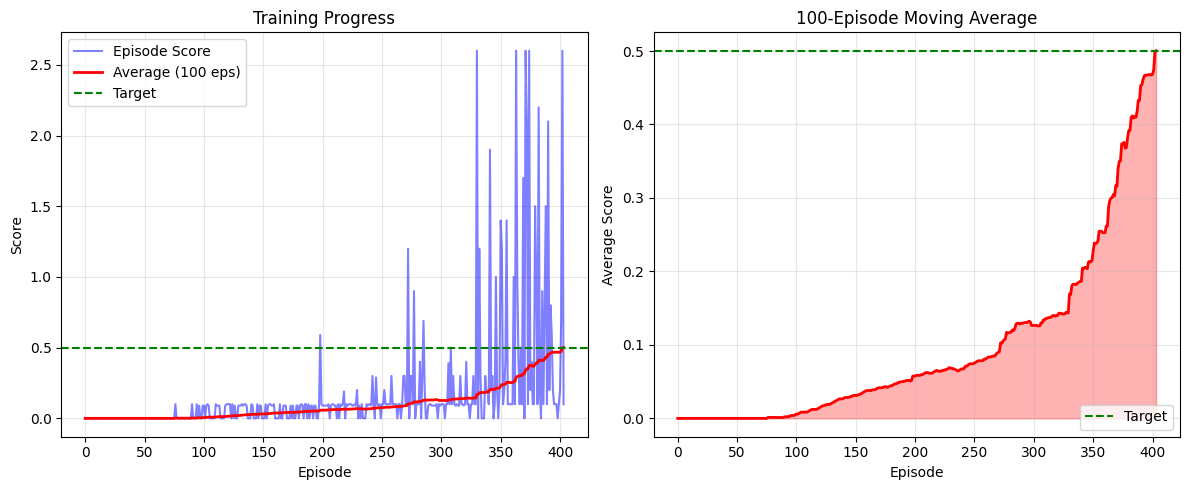


📊 Best average score: 0.500

🎮 Testing trained agent...
Episode 1: 0.100
Episode 2: 0.200
Episode 3: 2.600
Episode 4: 2.700
Episode 5: 0.100
Episode 6: 0.200
Episode 7: 2.600
Episode 8: 0.000
Episode 9: 2.600
Episode 10: 1.700

Average Score: 1.280

✅ Complete!


In [12]:
if __name__ == "__main__":
    agent, scores = main()